In [1]:
from torchsummary import summary # pip only

import numpy as np

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision 
import torchvision.datasets as datasets

%load_ext autoreload
%autoreload 2
    
import models
import data

In [12]:
device = torch.device('cuda:0')

torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

latent_size = 2
enc_sizes = [784,500,latent_size]
dec_sizes = [latent_size,500,784]
batch_size = 100
train = False

n_epochs = 200
n_batches_print = 100

conditional_size = 10

cvae_enc_sizes = enc_sizes.copy()
cvae_enc_sizes[0] += conditional_size

cvae_dec_sizes = dec_sizes.copy()
cvae_dec_sizes[0] += conditional_size

cvae_prior_network_sizes = [conditional_size, 5, latent_size]

cvae_enc_sizes, cvae_dec_sizes, cvae_prior_network_sizes

([794, 500, 2], [12, 500, 784], [10, 5, 2])

In [4]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: torch.round(x)),
    torchvision.transforms.Lambda(lambda x: x.view(-1)),
])

trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)

testset = datasets.MNIST(root='../data', train=False, download=True, transform=transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=8)

In [5]:
trainset[0][1]

5

torch.Size([100, 784]) torch.Size([100]) tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])


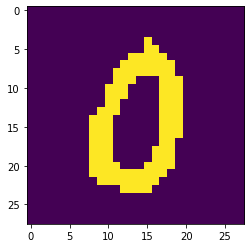

In [6]:
x,y = next(iter(trainloader))
print(x.shape, y.shape, torch.nn.functional.one_hot(y,10)[0])

plt.imshow(x[0].view(28,28))

In [ ]:
torch.cat((x, torch.nn.functional.one_hot(y,10).float()), 1).shape

In [29]:
cvae = models.CVAE(cvae_enc_sizes, cvae_dec_sizes, cvae_prior_network_sizes)
cvae.to(device)
print(cvae)

CVAE(
  (recognition_network): Encoder(
    (mlp): Sequential(
      (0): Sequential(
        (0): Linear(in_features=794, out_features=500, bias=True)
        (1): Tanh()
      )
    )
    (fc_mu): Linear(in_features=500, out_features=2, bias=True)
    (fc_logvariance): Linear(in_features=500, out_features=2, bias=True)
  )
  (recognition_sampling_layer): StochasticLayer()
  (prior_network): Encoder(
    (mlp): Sequential(
      (0): Sequential(
        (0): Linear(in_features=10, out_features=5, bias=True)
        (1): Tanh()
      )
    )
    (fc_mu): Linear(in_features=5, out_features=2, bias=True)
    (fc_logvariance): Linear(in_features=5, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (mlp): Sequential(
      (0): Sequential(
        (0): Linear(in_features=12, out_features=500, bias=True)
        (1): Tanh()
      )
    )
    (last_layer): Sequential(
      (0): Linear(in_features=500, out_features=784, bias=True)
      (1): Sigmoid()
    )
  )
)


In [ ]:
optimizer = torch.optim.Adam(cvae.parameters())

for epoch in range(n_epochs):

    running_loss = 0

    for it, (images, labels) in enumerate(trainloader):

        images, labels = images.to(device), labels.to(device)
        labels = nn.functional.one_hot(labels, conditional_size).float()

        out = cvae(images, labels)
        loss = -models.CVAE.variational_objective(images, *out)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss
        if it % n_batches_print == n_batches_print-1:
            print(f'[{epoch+1} {it+1}] loss: {running_loss/n_batches_print}')
            running_loss = 0.0

print('Finished Training')

torch.save(vae.state_dict(), "./cvae.pt")

[1 100] loss: 223.18182373046875
[1 200] loss: 167.0593719482422
[1 300] loss: 157.74334716796875
[1 400] loss: 154.23959350585938
[1 500] loss: 151.65328979492188
[1 600] loss: 149.1203155517578
[2 100] loss: 146.91635131835938
[2 200] loss: 144.77456665039062
[2 300] loss: 143.46336364746094
[2 400] loss: 141.84164428710938
[2 500] loss: 141.88943481445312
[2 600] loss: 139.6652069091797
[3 100] loss: 139.5169219970703
[3 200] loss: 137.48915100097656
[3 300] loss: 138.18275451660156
[3 400] loss: 135.80918884277344
[3 500] loss: 135.9220428466797
[3 600] loss: 136.08078002929688
[4 100] loss: 135.43186950683594
[4 200] loss: 134.73333740234375
[4 300] loss: 133.71017456054688
[4 400] loss: 133.71449279785156
[4 500] loss: 133.6317901611328
[4 600] loss: 132.6844024658203
[5 100] loss: 132.9744873046875
[5 200] loss: 133.35203552246094
[5 300] loss: 131.6920623779297
[5 400] loss: 132.23805236816406
[5 500] loss: 130.8469696044922
[5 600] loss: 131.3266143798828
[6 100] loss: 130.482

[42 100] loss: 120.28485107421875
[42 200] loss: 120.97447967529297
[42 300] loss: 121.48497772216797
[42 400] loss: 121.68321228027344
[42 500] loss: 121.20040130615234
[42 600] loss: 121.50517272949219
[43 100] loss: 120.48006439208984
[43 200] loss: 120.7411117553711
[43 300] loss: 121.43186950683594
[43 400] loss: 121.89122009277344
[43 500] loss: 120.43087005615234
[43 600] loss: 121.86043548583984
[44 100] loss: 121.59639739990234
[44 200] loss: 120.68988800048828
[44 300] loss: 121.0360336303711
[44 400] loss: 121.57837677001953
[44 500] loss: 121.11994934082031
[44 600] loss: 120.20574951171875
[45 100] loss: 121.2071762084961
[45 200] loss: 121.11624908447266
[45 300] loss: 120.86133575439453
[45 400] loss: 121.36619567871094
[45 500] loss: 120.23641967773438
[45 600] loss: 120.95929718017578
[46 100] loss: 121.3506088256836
[46 200] loss: 120.95436096191406
[46 300] loss: 120.62047576904297
[46 400] loss: 121.13243103027344
[46 500] loss: 120.84373474121094
[46 600] loss: 120

In [26]:
vae = models.VAE(enc_sizes,dec_sizes)

if not train:
    vae.load_state_dict(torch.load('vae.pt'))

vae.to(device)
print(vae)

VAE(
  (encoder): Encoder(
    (mlp): Sequential(
      (0): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): Tanh()
      )
    )
    (fc_mu): Linear(in_features=500, out_features=2, bias=True)
    (fc_logvariance): Linear(in_features=500, out_features=2, bias=True)
  )
  (stochasticlayer): StochasticLayer()
  (decoder): Decoder(
    (mlp): Sequential(
      (0): Sequential(
        (0): Linear(in_features=2, out_features=500, bias=True)
        (1): Tanh()
      )
    )
    (last_layer): Sequential(
      (0): Linear(in_features=500, out_features=784, bias=True)
      (1): Sigmoid()
    )
  )
)


In [17]:
if train:
        
    optimizer = torch.optim.Adam(vae.parameters())

    n_epochs = 200
    n_batches_print = 100

    for epoch in range(n_epochs):

        running_loss = 0

        for it, (images, labels) in enumerate(trainloader):

            images, labels = images.to(device), labels.to(device)

            mu, logvariance, z, y = vae(images)
            loss = -models.VAE.variational_objective(images, mu, logvariance, z, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss
            if it % n_batches_print == n_batches_print-1:
                print(f'[{epoch+1} {it+1}] loss: {running_loss/n_batches_print}')
                running_loss = 0.0

    print('Finished Training')
    
    torch.save(vae.state_dict(), "./vae.pt")

In [18]:
def test_model(vae, dataloader, device):
    elbo_avg = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        mu, logvariance, z, y = vae(x)
        elbo_avg += models.VAE.variational_objective(x, mu, logvariance, z, y)
    return elbo_avg/len(dataloader)


print(f"Training set ELBO = {test_model(vae, trainloader, device)}")
print(f"Test set ELBO     = {test_model(vae, testloader, device)}")

Training set ELBO = -130.44461059570312
Test set ELBO     = -151.35696411132812


In [ ]:
def imshow(img):
    plt.imshow(np.transpose(img.detach().numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [ ]:
# latent space visualization 
#     encode samples and visualize distribution in latent space


def latent_space_visualization(dataset, saveas=None, n_samples_per_class=100, device=torch.device('cuda:0')):

    import itertools

    viridis = plt.cm.get_cmap('viridis', 10)

    for c in range(10):

        x = itertools.islice(filter(lambda x: x[1] == c, dataset), n_samples_per_class)
        x = torch.stack(list(zip(*x))[0], 0)
        x = x.to(device)

        mu, _ = vae.encoder(x)
        mu = mu.cpu().detach().numpy()

        color = np.ones(n_samples_per_class) * c
        color = color.astype(np.uint8)

        plt.scatter(mu[:,0],mu[:,1],c=np.tile(np.array(viridis(c/10)),(n_samples_per_class,1)),alpha=0.5,label=f'{c}')

    plt.title('latent space visualization')
    plt.xlim((-6,6))
    plt.ylim((-6,6))
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.legend()

    if saveas:
        plt.savefig(saveas)
    
    
latent_space_visualization(trainset)

In [ ]:
def foo(a,b,c):
    print(a,b,c)
    
    
l = [2,3]
foo(1,*l)